# Finite Differencing for simplified 1d NS equation

Making a few assumptions, the equation takes the following form
$\frac{\partial u}{\partial t} + u \frac{\partial u }{\partial x} = -\frac{1}{\rho} \frac{\partial P}{\partial x} + \frac{\mu}{\rho}\frac{\partial^2 u}{\partial x^2}~,$

To solve the above equation, we use method of line for integration in time, and finite differencing for integration in space. 


Assuming uniform pressure, and 0 viscosity, we first solve the inviscid Burgers' equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finite_differencing_functions as fd

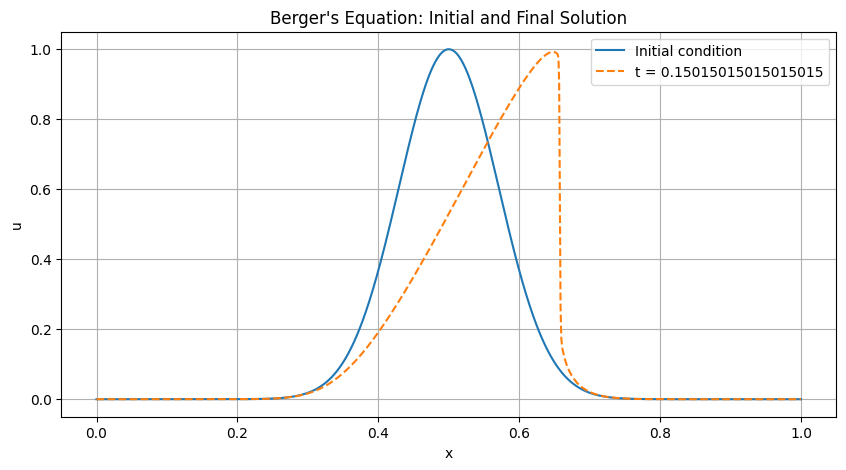

In [2]:
def plot_results(x, u_initial, u, tlim):
    """ Plot the initial and final solutions. """
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u, label='t = %s'%tlim, linestyle='--')
    plt.title('Berger\'s Equation: Initial and Final Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
nt = 300            # Number of time steps
c = 1

# CFL condition
dx = L / (nx - 1)
cfl = 0.5
assert cfl <= 1, "CFL condition violated, reduce time step or increase spatial resolution."

# Run the simulation
x, u_initial, u_final, tlim = fd.run_simulation_advective(nx, L, cfl, nt)

# Plot the results
plot_results(x, u_initial, u_final, tlim)


# Now add the dissipation (viscosity) term

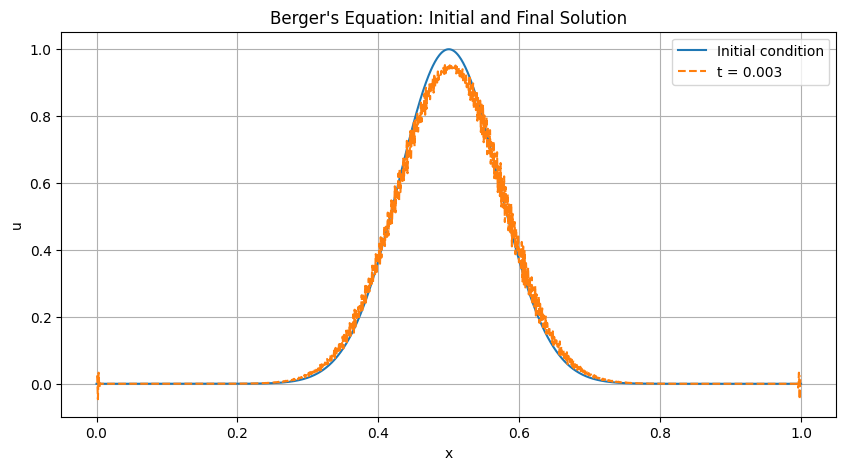

In [3]:
def plot_results(x, u_initial, u, tlim):
    """ Plot the initial and final solutions. """
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u, label='t = %s'%tlim, linestyle='--')
    plt.title('Berger\'s Equation: Initial and Final Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nt = 3              # Number of time steps
tlim = dt * nt      # End time for simulation
nu = 0.1            # Viscosity

# Initialize
dx = L / (nx - 1)
x, u_initial, u_final = fd.run_simulation_viscocity(nx, L, nu, dt, nt)

# Plot the results
plot_results(x, u_initial, u_final, tlim)

In [4]:
def plot_results(x, u_initial, u, tlim):
    """ Plot the initial and final solutions. """
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u, label=f't = {tlim}', linestyle='--')
    plt.title('Viscous Berger\'s Equation with Keisler-Oliver Dissipation')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nt = 3              # Number of time steps
tlim = dt * nt      # End time for simulation
nu = 0.1            # Viscosity

# Initialize
dx = L / (nx - 1)
x, u_initial, u_final = fd.run_simulation_KOdissipation(nx, L, nu, dt, nt)

# Plot the results
plot_results(x, u_initial, u_final, tlim)

NameError: name 'rk2_step_KOdissipation' is not defined